In [1]:
%load_ext autoreload
%matplotlib ipympl
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import bpy
from bpy.types import bpy_prop_array
import mathutils
import numpy as np
import clipboard

In [2]:
import sys
sys.path.append('/Users/orenm/BlenderShaderProject/project_files/')

In [3]:
%autoreload 2
from Logic.node_readers_writers import *
from Logic.network_manager import NetworkManager
from Logic.meta_network import *
from Logic.structures_definitions import *
from Logic.variations_creator import *

In [4]:
self = NetworkManager()
self.initialize_network()
self.generate_random_network(n_additions=4)
self.finish_network()

code = self.generate_code(with_initialization_code=True)
clipboard.copy(code)
# self.draw_network()

In [5]:
# manager = MetaNetworkManager(ALL_META_NODES, max_layers=1, n_additions=1)
# manager.generate_network()
# nm = manager.meta_network_to_flat_network()
nm = self

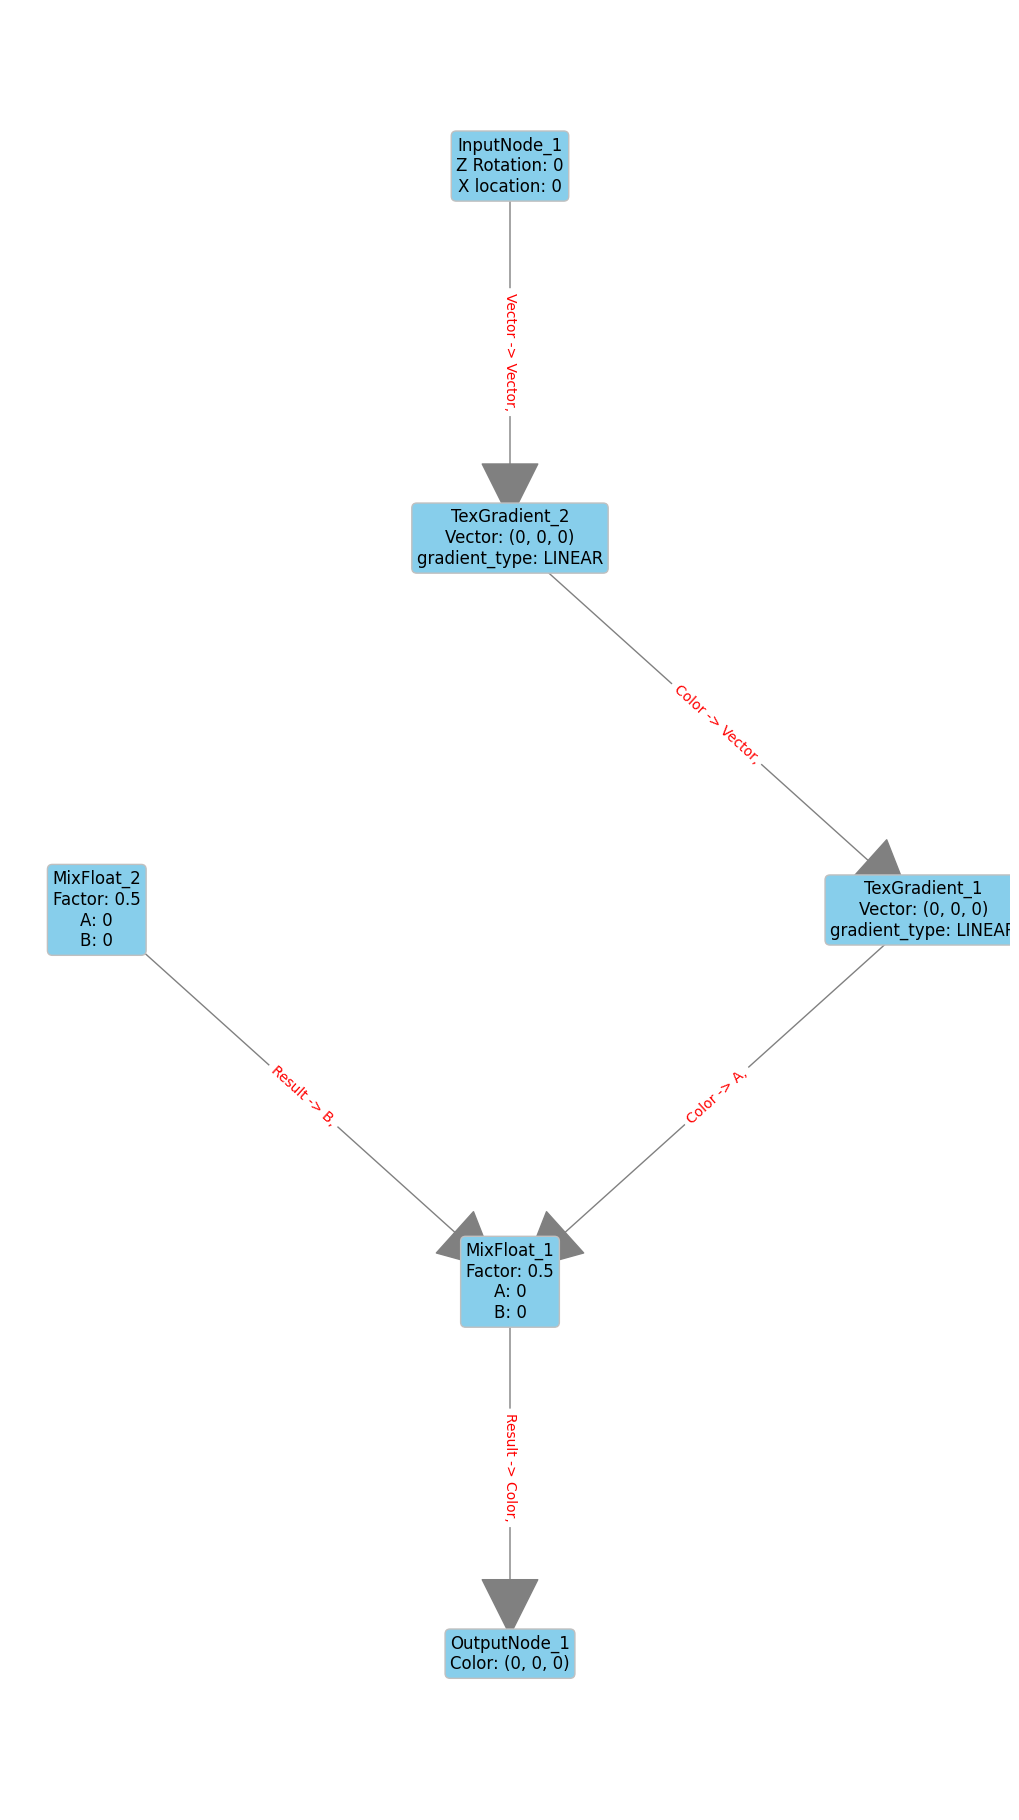

In [6]:
nm.draw_network()

In [ ]:
step['in_node'], step['out_node'], step['in'], step['out']

In [69]:
variation = backwards
step = variation.step
variation.variation_type, step

(<VariationType.ADD_EDGE: 6>,
 {'in_node': 'SeparateXYZ_1',
  'out_node': 'TexGradient_1',
  'in': 'Vector',
  'out': 'Color'})

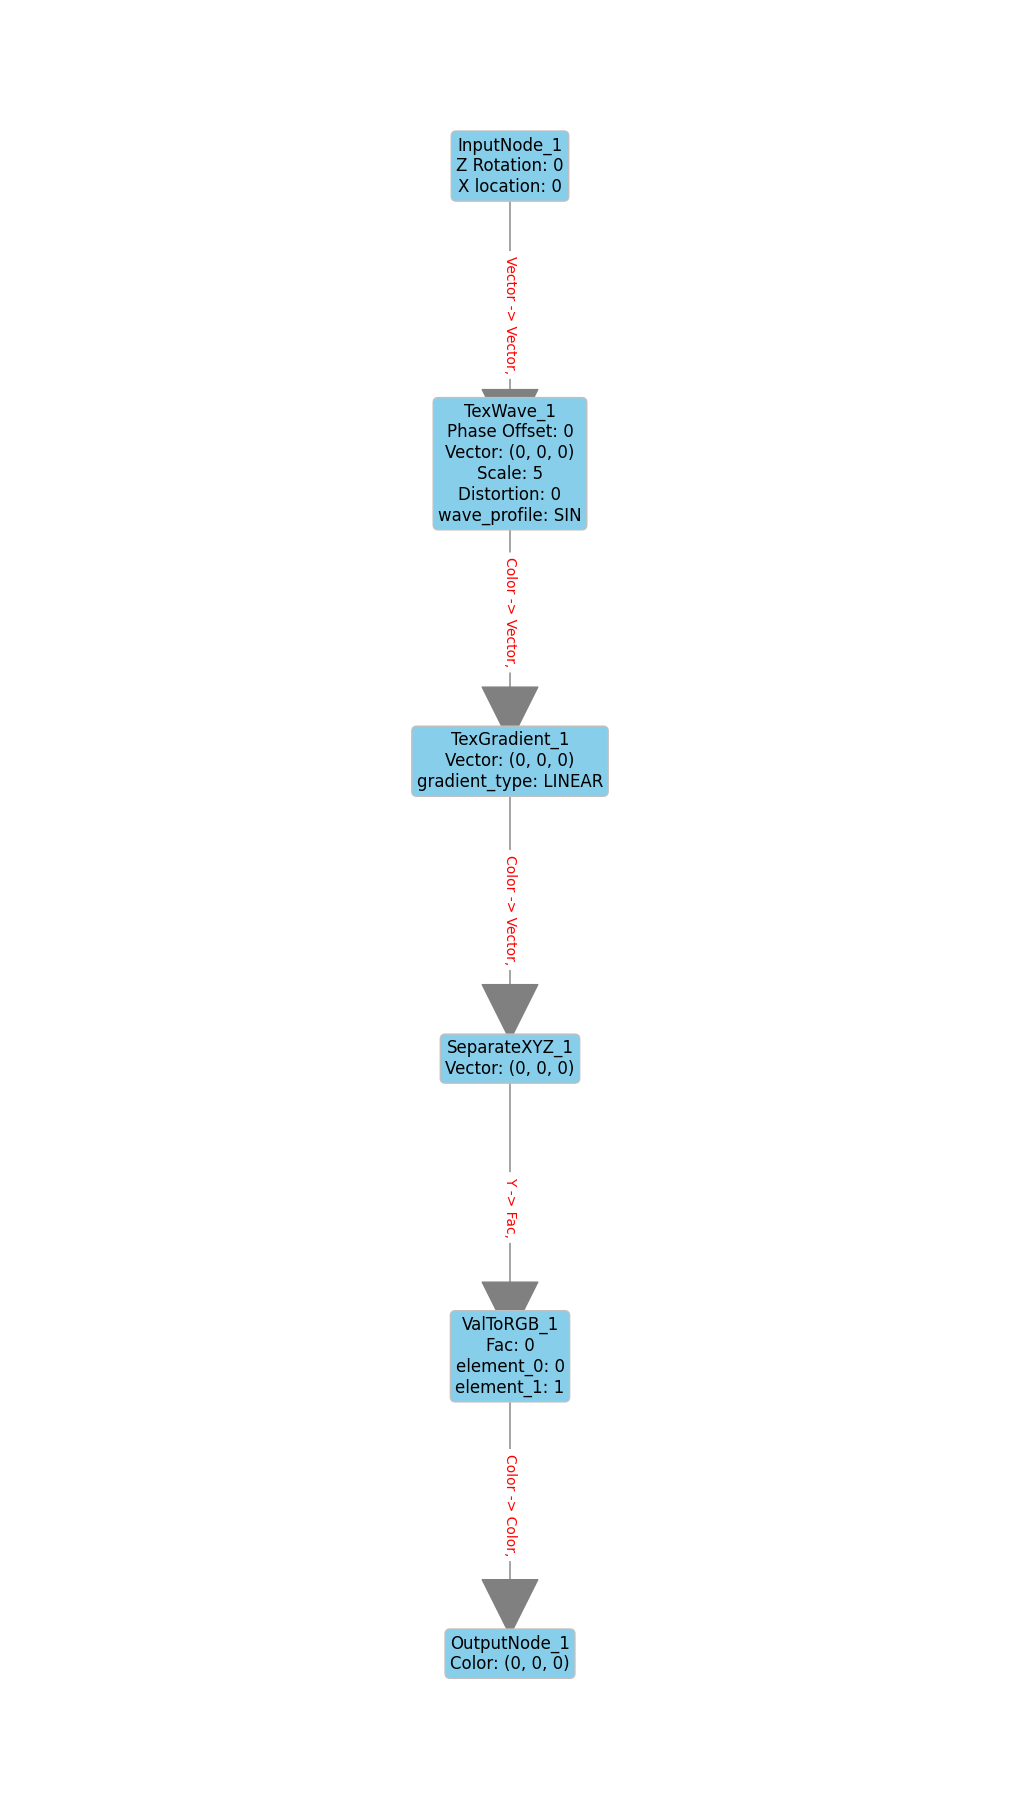

In [71]:
nm.draw_network()

In [ ]:
# rand node
# make sure it has an input (not value node)
# get all nodes not decendants
# randomly select node and out
# remove input to node if there is one
# connect

# reverse - if there was another connection, or just remove...

In [39]:
variation = desc.steps_forward[0]
variation.step

{'edge': ('InputNode_1', 'TexWave_1', {'out': 'Vector', 'in': 'Vector'}),
 'new_node': 'TexWave',
 'new_node_in': 'Vector',
 'new_node_out': 'Color'}

In [40]:
variation = desc.steps_backward[0]

In [41]:
nm.calc_layers()

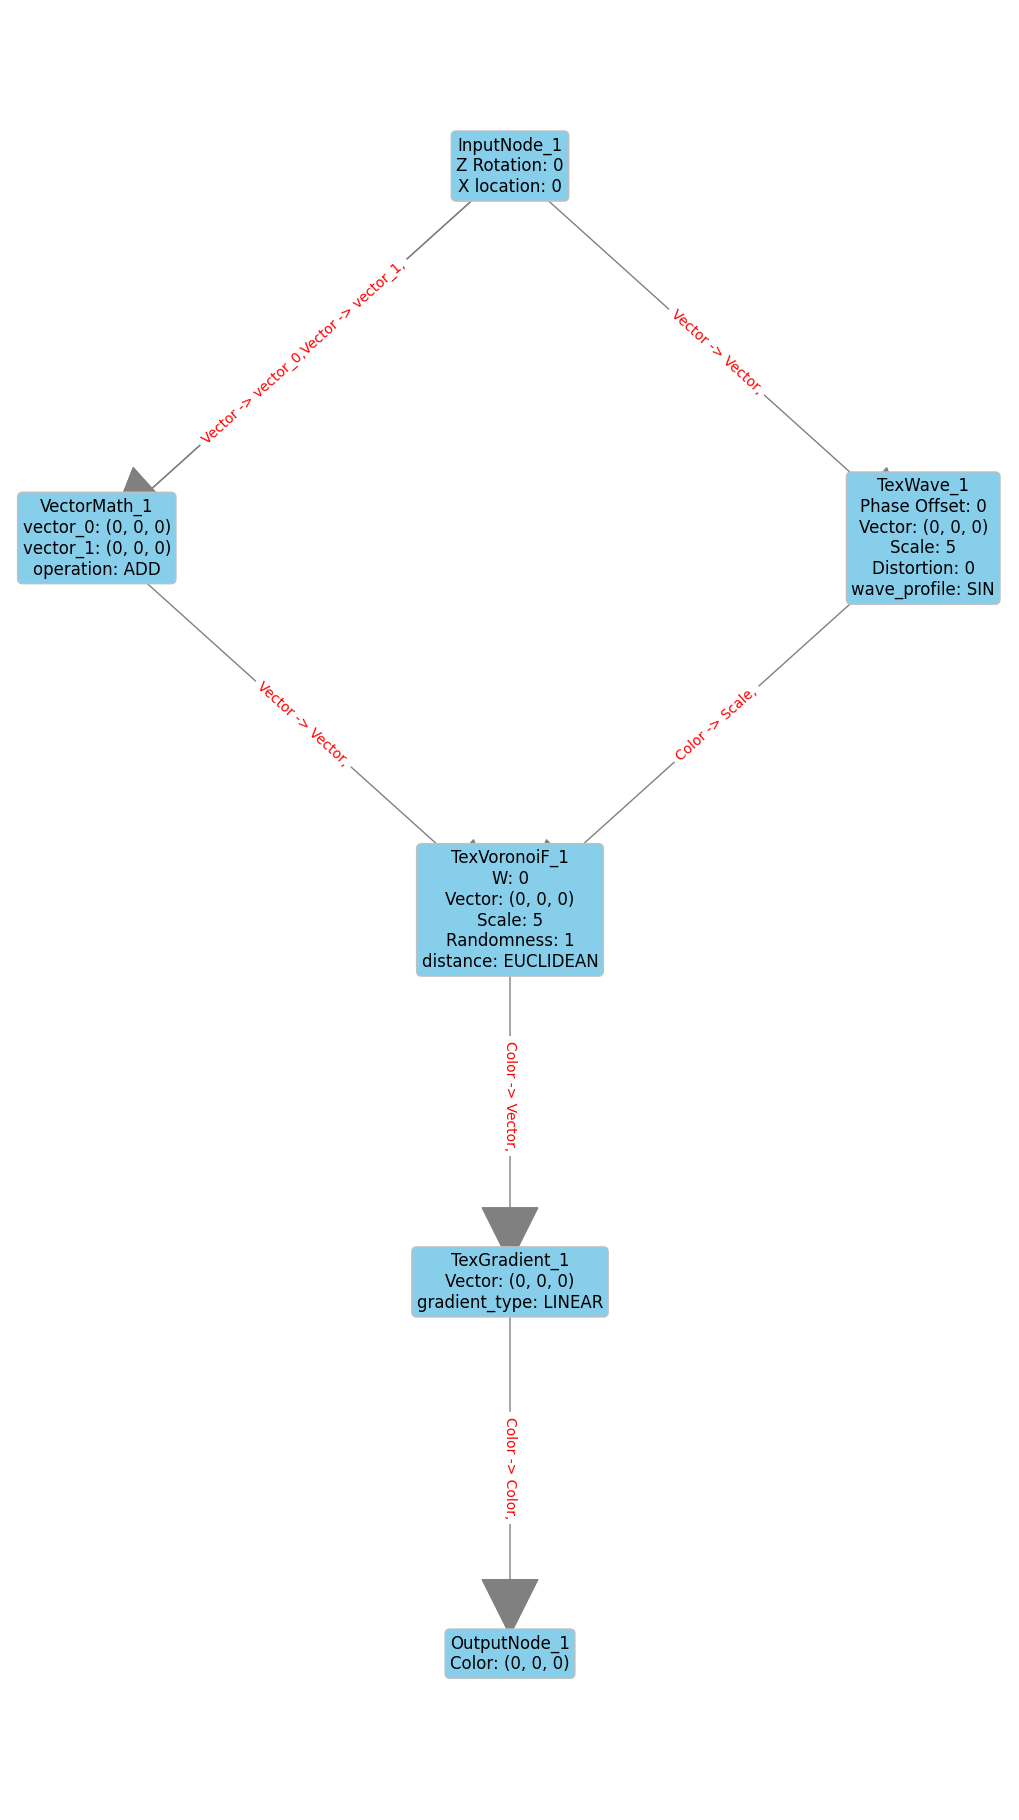

In [42]:
nm.draw_network()

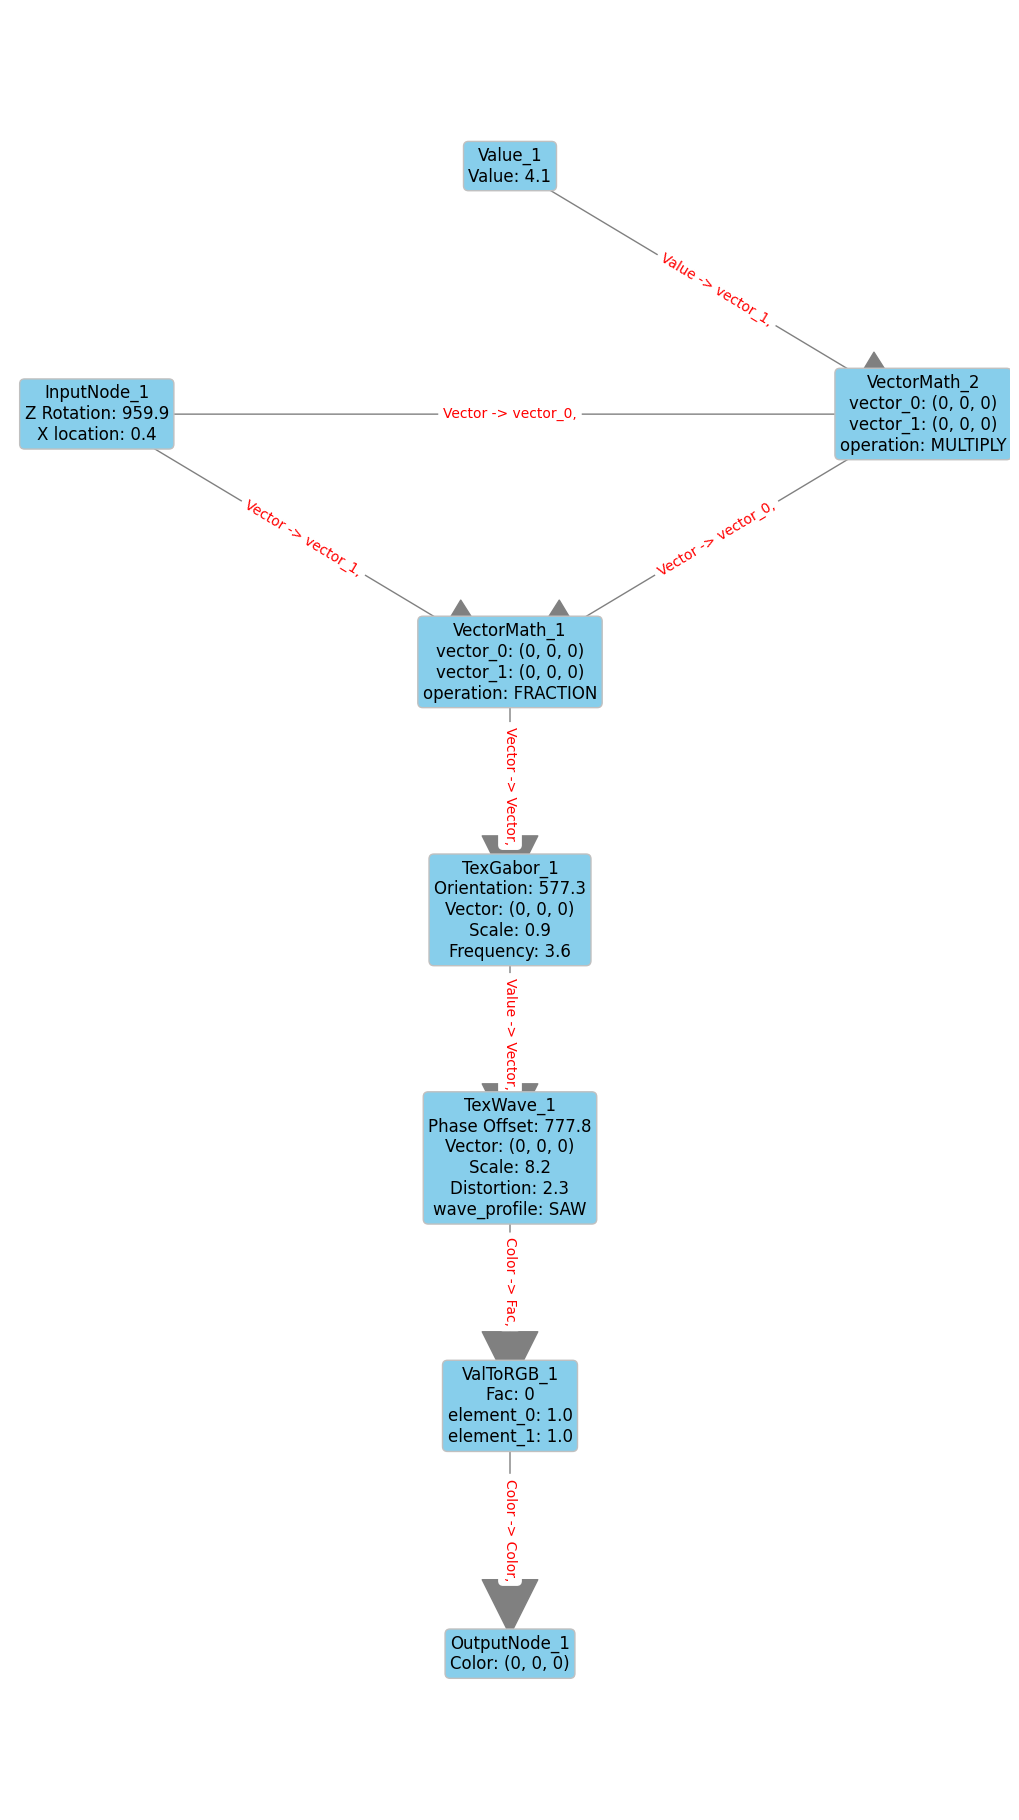

In [188]:


dist_vals = nm.get_all_nodes_values(ParamRequestType.ALL, return_ranges=True, not_input_values=True)
nm.apply_distribution_limitations(dist_vals)
new_vals = nm.pick_random_values_from_dict(dist_vals)
nm.set_nodes_attributes(new_vals)

code = nm.generate_code(with_initialization_code=True)
clipboard.copy(code)
nm.draw_network()

In [178]:
dist_vals = nm.get_all_nodes_values(ParamRequestType.NUMERIC, return_ranges=True, not_input_values=True)
nm.apply_distribution_limitations(dist_vals)
new_vals = nm.pick_random_values_from_dict(dist_vals)
nm.set_nodes_attributes(new_vals)

code = nm.generate_code(with_initialization_code=True)
clipboard.copy(code)

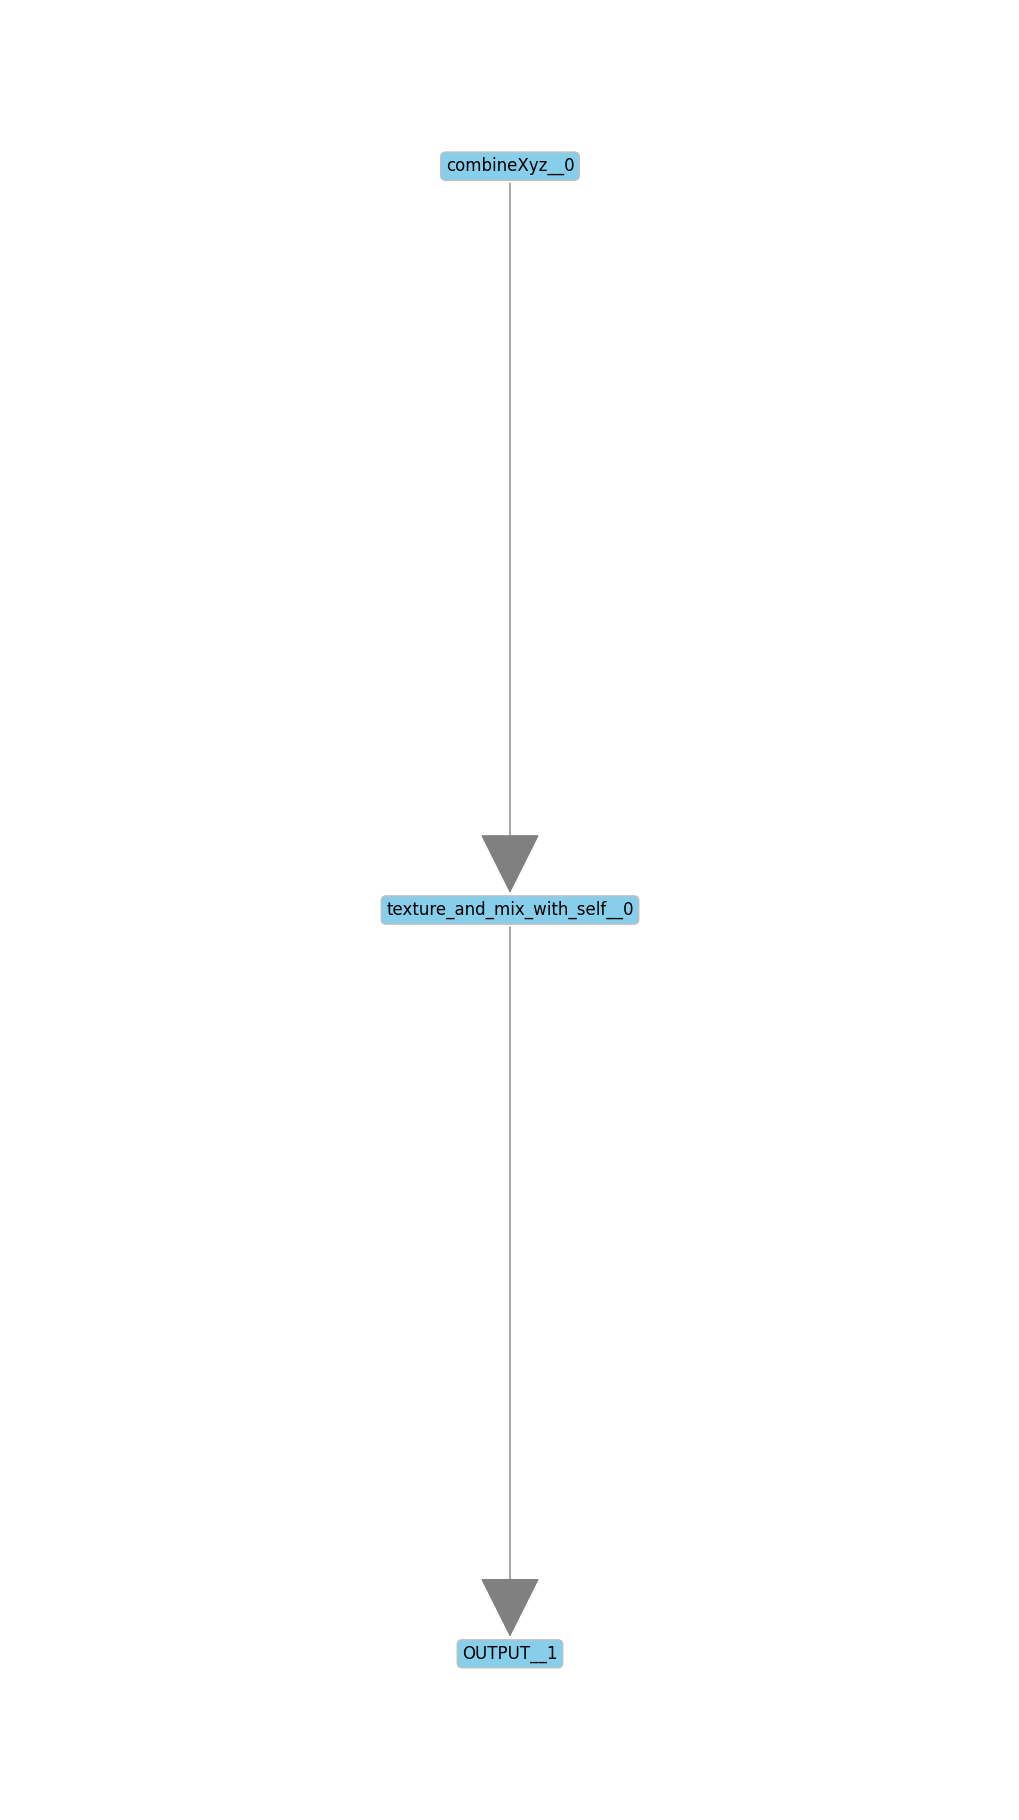

In [19]:
manager.draw_network()